## Install and Import Dependencies

In [1]:
pip install kagglehub matplotlib seaborn numpy tensorflow

In [2]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

## Loading Dataset

In [3]:
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1


## Data Preprocessing

#### Datagen to Transform Data

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_data = train_datagen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/training_set/training_set',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
)

test_data = val_datagen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/test_set/test_set',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## InceptionV3

In [6]:
base_iv3 = InceptionV3(weights = 'imagenet',
                       include_top = False,
                       input_shape = (224, 224, 3))

#### Total Layers in InceptionV3

In [7]:
len(base_iv3.layers)

311

#### Freezing all Layers

In [8]:
base_iv3.trainable = False

#### Unfreezing Last 10 Layers for Fine Tuning

In [9]:
for layers in base_iv3.layers[-10:]:
  layers.trainable = True

#### Model Architecture

In [10]:
inputs = Input(shape = (224, 224, 3))
x = base_iv3(inputs)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

classifier = Model(inputs = inputs, outputs = outputs)

#### Trainable and UnTrainable Parameters (Summary)

In [11]:
classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,149,281 (183.67 MB)

 Trainable params: 26,346,689 (100.50 MB)

 Non-trainable params: 21,802,592 (83.17 MB)

#### Compile Model

In [12]:
classifier.compile(optimizer = Adam(learning_rate = 0.001),
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

#### Model Training

In [13]:
history = classifier.fit(train_data,
                         epochs = 5,
                         batch_size = 32,
                         validation_data = test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 513ms/step - accuracy: 0.9313 - loss: 1.6649 - val_accuracy: 0.9644 - val_loss: 0.4051
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 119s 463ms/step - accuracy: 0.9801 - loss: 0.1744 - val_accuracy: 0.9822 - val_loss: 0.0956
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 454ms/step - accuracy: 0.9842 - loss: 0.0708 - val_accuracy: 0.9886 - val_loss: 0.0470
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 109s 433ms/step - accuracy: 0.9869 - loss: 0.0510 - val_accuracy: 0.9871 - val_loss: 0.0639
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 104s 414ms/step - accuracy: 0.9862 - loss: 0.0564 - val_accuracy: 0.9881 - val_loss: 0.0446


#### Evaluation

In [14]:
class_loss, class_acc = classifier.evaluate(test_data)

print("Loss of Classification     :", class_loss)
print("Accuracy of Classification :", class_acc * 100, "%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9890 - loss: 0.0385
Loss of Classification     : 0.04455431550741196
Accuracy of Classification : 98.81364107131958 %


### Visualization of Accuracy and Loss Over Epochs

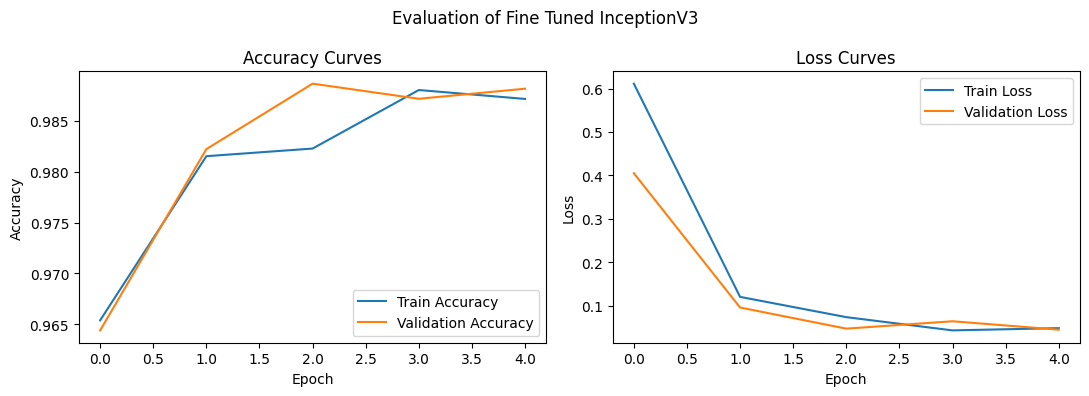

In [15]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
sns.lineplot(x = history.epoch, y = history.history['accuracy'], label = 'Train Accuracy')
sns.lineplot(x = history.epoch, y = history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
sns.lineplot(x = history.epoch, y = history.history['loss'], label = 'Train Loss')
sns.lineplot(x = history.epoch, y = history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')

plt.suptitle('Evaluation of Fine Tuned InceptionV3')
plt.tight_layout()

plt.show()

## VGG19

In [23]:
base_vgg = VGG19(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224, 224, 3))

#### Freezing all Layers

In [24]:
base_vgg.trainable = False

#### UnFreezing last 3 Layers for Fine Tuning

In [25]:
for layers in base_vgg.layers[-3:]:
  layers.trainable = True

#### Model Architecture

In [26]:
inputs = Input(shape = (224, 224, 3))
x = base_vgg(inputs)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

classifier_vgg = Model(inputs = inputs, outputs = outputs)

#### Summary

In [27]:
classifier_vgg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,001,537 (125.89 MB)

 Trainable params: 17,696,769 (67.51 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

#### Model Compilation

In [28]:
classifier_vgg.compile(optimizer = Adam(learning_rate = 0.001),
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy'])

#### Training Model

In [29]:
history_vgg = classifier_vgg.fit(train_data,
                                 epochs = 5,
                                 batch_size = 32,
                                 validation_data = test_data)

Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 130s 500ms/step - accuracy: 0.7604 - loss: 0.6776 - val_accuracy: 0.9036 - val_loss: 0.2157
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 491ms/step - accuracy: 0.9010 - loss: 0.2469 - val_accuracy: 0.9179 - val_loss: 0.1977
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 482ms/step - accuracy: 0.9282 - loss: 0.1838 - val_accuracy: 0.9348 - val_loss: 0.1677
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 481ms/step - accuracy: 0.9401 - loss: 0.1532 - val_accuracy: 0.9214 - val_loss: 0.2626
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 120s 476ms/step - accuracy: 0.9387 - loss: 0.1587 - val_accuracy: 0.9392 - val_loss: 0.1724


#### Evaluation

In [30]:
vgg_loss, vgg_acc = classifier_vgg.evaluate(test_data)

print("Loss of Classification     :", vgg_loss)
print("Accuracy of Classification :", vgg_acc * 100, "%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9325 - loss: 0.1840
Loss of Classification     : 0.1724252700805664
Accuracy of Classification : 93.91992092132568 %


### Visualization of Accuracy and Loss over Epochs

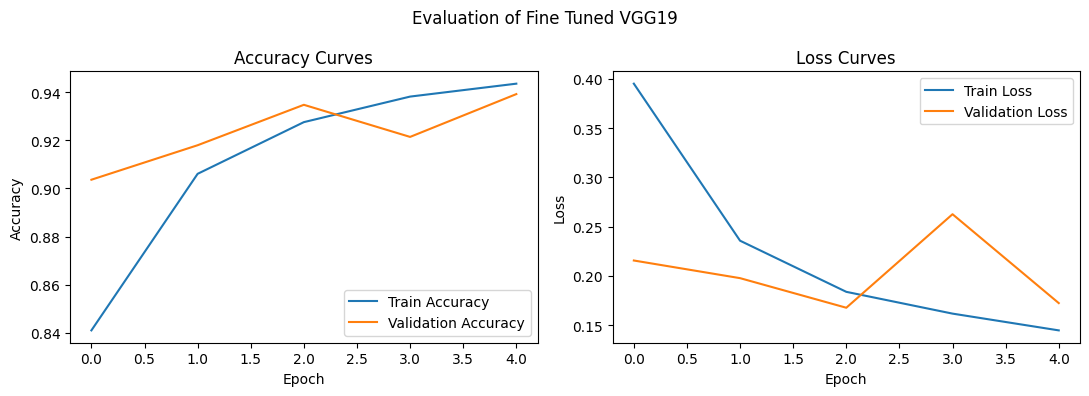

In [31]:
plt.figure(figsize = (11, 4))

plt.subplot(1, 2, 1)
sns.lineplot(x = history_vgg.epoch, y = history_vgg.history['accuracy'], label = 'Train Accuracy')
sns.lineplot(x = history_vgg.epoch, y = history_vgg.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
sns.lineplot(x = history_vgg.epoch, y = history_vgg.history['loss'], label = 'Train Loss')
sns.lineplot(x = history_vgg.epoch, y = history_vgg.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')

plt.suptitle('Evaluation of Fine Tuned VGG19')
plt.tight_layout()

plt.show()

## Making Predictions

#### PreProcess User Inputted Image

In [32]:
def predict_image(model, img_path):
  img = image.load_img(img_path, target_size = (224, 224, 3))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.
  prediction = model.predict(img_array)
  if prediction[0][0] > 0.5:
    return "Dog"
  else:
    return "Cat"

#### Predictions along with User Image

Enter the path to the image: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/test_set/test_set/cats/cat.4021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction : Cat


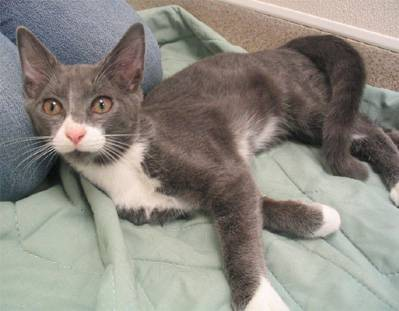

In [33]:
user_input = input("Enter the path to the image: ")
prediction = predict_image(classifier, user_input)

print("Prediction :", prediction)
Image(user_input)